# Mario Filho - Prophet

link youtube: https://www.youtube.com/watch?v=4kWROiUYHBc&ab_channel=MarioFilho

dataset: https://www.kaggle.com/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region/

É um dataSet com dados meteorologicos de várias cidades do Brasil, vamos escolher Uma delas.

A contagem é: Uma mediçâo por hora, asism num ano tem 8760 medições.

Vamos buscar e prever a temperatura máxima `tmax` com base no dia `mdct`

---

O prophet suporta a TS mais simples, a data e o dia da medição. Com esses addos é possível já prever.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Configs
pd.options.display.float_format = '{:,.4f}'.format
sns.set(style="whitegrid")
plt.style.use('seaborn')
seed = 42
np.random.seed(seed)
random.seed(seed)

/kaggle/input/hourly-weather-surface-brazil-southeast-region/sudeste.csv


In [2]:
# ja vamos importar e ja converter a data para o formato correto
data = pd.read_csv("/kaggle/input/hourly-weather-surface-brazil-southeast-region/sudeste.csv", parse_dates=['mdct', 'date'])
data.sort_values("mdct", inplace=True)

In [3]:
data.head()

wsid               wsnm    elvt      lat      lon  inme        city  \
5493152   371  ECOLOGIA AGRÍCOLA 35.0000 -22.7579 -43.6848  A601  Seropédica   
5493153   371  ECOLOGIA AGRÍCOLA 35.0000 -22.7579 -43.6848  A601  Seropédica   
5493154   371  ECOLOGIA AGRÍCOLA 35.0000 -22.7579 -43.6848  A601  Seropédica   
5493155   371  ECOLOGIA AGRÍCOLA 35.0000 -22.7579 -43.6848  A601  Seropédica   
5493156   371  ECOLOGIA AGRÍCOLA 35.0000 -22.7579 -43.6848  A601  Seropédica   

        prov                mdct       date  ...   tmax   dmax   tmin   dmin  \
5493152   RJ 2000-05-24 00:00:00 2000-05-24  ... 0.0000 0.0000 0.0000 0.0000   
5493153   RJ 2000-05-24 01:00:00 2000-05-24  ... 0.0000 0.0000 0.0000 0.0000   
5493154   RJ 2000-05-24 02:00:00 2000-05-24  ... 0.0000 0.0000 0.0000 0.0000   
5493155   RJ 2000-05-24 03:00:00 2000-05-24  ... 0.0000 0.0000 0.0000 0.0000   
5493156   RJ 2000-05-24 04:00:00 2000-05-24  ... 0.0000 0.0000 0.0000 0.0000   

          hmdy   hmax   hmin   wdsp   wdct   gust  
5493152 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  
5493153 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  
5493154 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  
5493155 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  
5493156 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  

[5 rows x 31 columns]

In [4]:
# Listando as 30 cidades com mais ocorrencias
data['wsnm'].value_counts().head(30)

ECOLOGIA AGRÍCOLA      143376
BAURU                  132264
CAMPOS DO JORDÃO       127584
XEREM                  122256
MARAMBAIA              121824
CAMBUCÍ                121536
BARBACENA              121176
FRANCA                 121008
ALMENARA               120936
UBERLÂNDIA             120864
ARAXÁ                  120840
MONTES CLAROS          120840
PRESIDENTE PRUDENTE    119712
MONTE VERDE            103296
VIÇOSA                  96816
TIMÓTEO                 92976
ITUIUTABA               91080
S.J.DEL REI             90408
VARGINHA                89592
CAMPINA VERDE           89544
PASSOS                  89472
CONC. DAS ALAGOAS       89472
IGUAPE                  89424
ITAPEVA                 89304
SAO PAULO               89304
OURO BRANCO             89232
S. MIG. ARCANJO         88800
FORMIGA                 88752
SACRAMENTO              88704
SERRA DOS AIMORES       88656
Name: wsnm, dtype: int64

In [5]:
# Selecionando os dados de Uberlandia
data_udi = data[data['wsnm'] == 'UBERLÂNDIA']

In [6]:
# Crio a coluna boolean se a mediçâo de temperatura está zerada ou não 
data_udi['zero'] = data_udi['tmax'] == 0

In [7]:
# agrupo por ano
data_udi.groupby(data_udi['date'].dt.year)['zero'].sum()

date
2002     336
2003    3722
2004    7084
2005    2347
2006     454
2007      88
2008    1750
2009      24
2010      84
2011      16
2012       7
2013      27
2014       2
2015       1
2016      26
Name: zero, dtype: int64

In [8]:
# 8760 é a quantidade de mediçêos maximas, uma a cada hora para todos os dias do ano
data_udi.groupby(data_udi['date'].dt.year)['zero'].sum() / 8760
# Vou abservar a quantidade de dados invalidos por anos

date
2002   0.0384
2003   0.4249
2004   0.8087
2005   0.2679
2006   0.0518
2007   0.0100
2008   0.1998
2009   0.0027
2010   0.0096
2011   0.0018
2012   0.0008
2013   0.0031
2014   0.0002
2015   0.0001
2016   0.0030
Name: zero, dtype: float64

In [9]:
# Vamos pegar os dados apartir de 2009 Pois tem mais dados limpos
data_udi = data_udi[data_udi['date'] > "2009-01-01"]

## Testando com poucos dados

Antes de tentar prever tudo, vamos verificar se a partir do dia anterior conseguimos prever o proximo. Assim vamo criar os datasets `train` e  `test` que terao as 24 medidas de um dia e de outro, e usar esses dado para preveralgo minimo

In [10]:
# Preparando para o prophet
## Ele decomenda que a data seja renomeada para 'd' e a coluna alvo para 'y'
tmax = data_udi[['mdct','tmax']]
tmax.columns = ['ds', 'y']
tmax.tail()

ds       y
1266235 2016-09-30 19:00:00 35.4000
1266236 2016-09-30 20:00:00 35.2000
1266237 2016-09-30 21:00:00 33.6000
1266238 2016-09-30 22:00:00 32.6000
1266239 2016-09-30 23:00:00 30.3000

In [11]:
train = tmax[tmax['ds'].dt.date == pd.to_datetime('2015-06-26')]
test = tmax[tmax['ds'].dt.date == pd.to_datetime('2015-06-27')]
train.shape, test.shape

((24, 2), (24, 2))

In [12]:
# Mean Absolute Percentage Error - erro médio percentual absoluto
def mape(ytrue, ypred): 
    ytrue, ypred = ytrue.values, ypred.values
    return np.mean( np.abs((ytrue - ypred) / ytrue) )

In [13]:
print("baseline", mape(test['y'], train['y']))

baseline 0.052108779432220816


In [14]:
from fbprophet import Prophet
prophet = Prophet()
prophet.fit(train)

In [15]:
?prophet.make_future_dataframe
"""
Signature: prophet.make_future_dataframe(periods, freq='D', include_history=True)
Docstring:
Simulate the trend using the extrapolated generative model.

Parameters
----------
periods: Int number of periods to forecast forward.
freq: Any valid frequency for pd.date_range, such as 'D' or 'M'.
include_history: Boolean to include the historical dates in the data
    frame for predictions.

Returns
-------
pd.Dataframe that extends forward from the end of self.history for the
requested number of periods.
File:      /opt/conda/lib/python3.7/site-packages/fbprophet/forecaster.py
Type:      method
"""

"\nSignature: prophet.make_future_dataframe(periods, freq='D', include_history=True)\nDocstring:\nSimulate the trend using the extrapolated generative model.\n\nParameters\n----------\nperiods: Int number of periods to forecast forward.\nfreq: Any valid frequency for pd.date_range, such as 'D' or 'M'.\ninclude_history: Boolean to include the historical dates in the data\n    frame for predictions.\n\nReturns\n-------\npd.Dataframe that extends forward from the end of self.history for the\nrequested number of periods.\nFile:      /opt/conda/lib/python3.7/site-packages/fbprophet/forecaster.py\nType:      method\n"

In [16]:
# Preparar DataFrame para Prever as proximas 24 horas
future = prophet.make_future_dataframe(24, include_history=False, freq='H')
print(future.shape)
future.head()

(24, 1)


ds
0 2015-06-27 00:00:00
1 2015-06-27 01:00:00
2 2015-06-27 02:00:00
3 2015-06-27 03:00:00
4 2015-06-27 04:00:00

In [17]:
# Fazer a previsão
p = prophet.predict(future)
p.head()
# trend, yhat são os mais importantes

ds   trend  yhat_lower  yhat_upper  trend_lower  \
0 2015-06-27 00:00:00 23.0527     20.2454     26.0620      23.0527   
1 2015-06-27 01:00:00 23.3480     20.4975     26.2047      23.3480   
2 2015-06-27 02:00:00 23.6433     20.9819     26.4500      23.6433   
3 2015-06-27 03:00:00 23.9387     20.7570     26.5819      23.9386   
4 2015-06-27 04:00:00 24.2340     21.4060     27.3101      24.2339   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0      23.0527          0.0000                0.0000                0.0000   
1      23.3480          0.0000                0.0000                0.0000   
2      23.6434          0.0000                0.0000                0.0000   
3      23.9387          0.0000                0.0000                0.0000   
4      24.2341          0.0000                0.0000                0.0000   

   multiplicative_terms  multiplicative_terms_lower  \
0                0.0000                      0.0000   
1                0.0000                      0.0000   
2                0.0000                      0.0000   
3                0.0000                      0.0000   
4                0.0000                      0.0000   

   multiplicative_terms_upper    yhat  
0                      0.0000 23.0527  
1                      0.0000 23.3480  
2                      0.0000 23.6433  
3                      0.0000 23.9387  
4                      0.0000 24.2340

In [18]:
# Avaliando
mape(test['y'], p['yhat'])

# Perceba que antes o erro era de 0.052 e agora de 0.46; Piorou muito

0.468551499577263

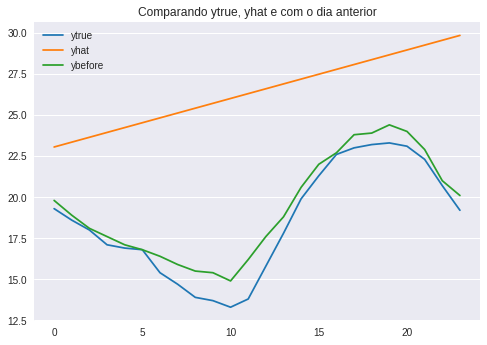

In [19]:
# grafico comparando nossa prediçâo, com o dado verdadeiro e o do dia anterior
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
xdata1 = range(0,24)
ax.plot(xdata1, test['y'], color='tab:blue', label='ytrue')
ax.plot(xdata1, p['yhat'], color='tab:orange', label='yhat')
ax.plot(xdata1, train['y'], color='tab:green', label='ybefore')
plt.grid(axis='x', color='0.95')
plt.legend()
plt.title('Comparando ytrue, yhat e com o dia anterior')
plt.show()

Vimos que com somente um dia anterior o prophet foi terrivel, vamos epgar umpouco mais de tempo,

In [20]:
# Vamos agorar pegar um dia a mais, agora serao dois dias 25 e 26 para prever o dia 27
train = tmax[tmax['ds'].isin(pd.date_range('2015-06-25', '2015-06-26 23:59:00', freq='H'))]

In [21]:
def run_prophet(train, test):
    prophet = Prophet()
    prophet.fit(train)
    
    future = prophet.make_future_dataframe(24, include_history=False, freq='H')
    fcst = prophet.predict(future) #fcst = forecast = previsão
    
    return prophet, fcst, mape(test['y'], fcst['yhat'])

def plot_compare_preds(ytrue, yhat, title=''):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    xdata1 = range(0,24)
    ax.plot(xdata1, ytrue, color='tab:blue', label='ytrue')
    ax.plot(xdata1, yhat, color='tab:orange', label='yhat')
    plt.grid(axis='x', color='0.95')
    plt.legend()
    plt.title(title)
    plt.show()

In [22]:
r = run_prophet(train, test)
print('mape:', r[-1])
plot_compare_preds(test['y'], r[1]['yhat'], 'Pegando dois dias')

mape: 0.20700270765736847


Agora saimos de 0.46 para 0.20

In [23]:
# Vamos pegar 1 semna agora
train = tmax[tmax['ds'].isin(pd.date_range('2015-06-20', '2015-06-26 23:59:00', freq='H'))]
r = run_prophet(train, test)
print('mape:', r[-1])
plot_compare_preds(test['y'], r[1]['yhat'], 'Pegando 1 semana')

mape: 0.03554791829817348


Ficamos menores do que a baseline de `0.052`. Não quer dizer que ele é perfeito

Vamos testar com outros periodo maiores.

mape: 0.06223818172180904


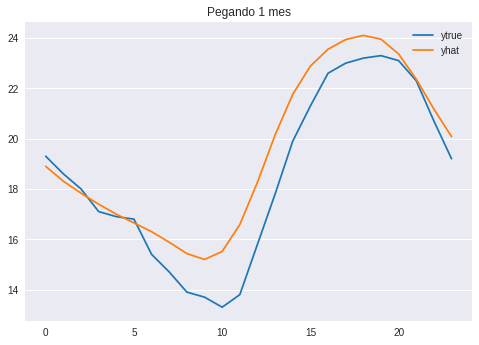

In [24]:
# 1 mes
train = tmax[tmax['ds'].isin(pd.date_range('2015-05-26', '2015-06-26 23:59:00', freq='H'))]
r = run_prophet(train, test)
print('mape:', r[-1])
plot_compare_preds(test['y'], r[1]['yhat'], 'Pegando 1 mes')

Com 1 mes piorou.

In [25]:
train = tmax[tmax['ds'].isin(pd.date_range('2015-04-26', '2015-06-26 23:59:00', freq='H'))]
r = run_prophet(train, test)
print('mape:', r[-1])
plot_compare_preds(test['y'], r[1]['yhat'], 'Pegando 2 meses')

mape: 0.05407453773228324


In [26]:
train = tmax[tmax['ds'].isin(pd.date_range('2015-01-01', '2015-06-26 23:59:00', freq='H'))]
r = run_prophet(train, test)
print('mape:', r[-1])
plot_compare_preds(test['y'], r[1]['yhat'], 'Pegando 6 meses')

mape: 0.19978382436477013


Enfim, o modelo, se adicionar mais dados, tende a piorar.

In [27]:
# Vamos salvar o melhor modelo, o de 7 dias
train = tmax[tmax['ds'].isin(pd.date_range('2015-06-19', '2015-06-26 23:59:00', freq='H'))]
prophet_7d, fcst, erro = run_prophet(train, test)

In [28]:
test['y'].plot(figsize=(15,7))

<AxesSubplot:>

Avaliando nossas previsões

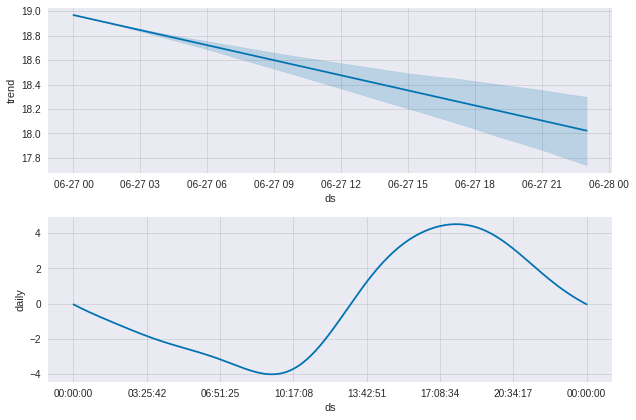

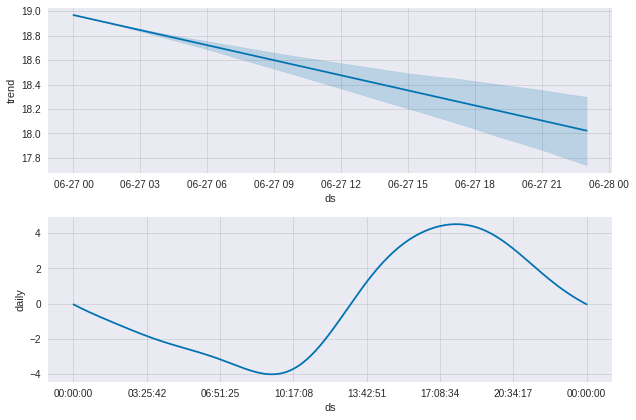

In [29]:
# Acabou duplicando os gráficos
prophet_7d.plot_components(fcst)
# temos a tendencia (trend) e o que ele calculou (daily)

## Fazeno CrossValidation

O phophet faz validaçâo cruzada com `from fbprophet.diagnostics import cross_validation`.  Ele pega toda a serie e faz

(initial='28 days', period='7 days', horizon = '7 days')

Ele vai pegar 28 dias e prever os pŕoximos 7 dias, após isso ele vai andar com essa janela em 7 dias. Ou seja, estamos preverndo os dados de toda uma semana apartir das 4 semans anteriores. É uma validaçâo de bloco em janela deslizante

In [30]:
train = tmax[tmax['ds'].isin(pd.date_range('2014-01-01', '2014-12-31 23:59:00', freq='H'))]
prophet_2014, fcst, erro = run_prophet(train, test)

In [31]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(prophet_2014, initial='28 days', period='7 days', horizon = '7 days')
df_cv.head()
# 4 min

  0%|          | 0/48 [00:00<?, ?it/s]

ds    yhat  yhat_lower  yhat_upper       y  \
0 2014-01-30 00:00:00 24.5975     22.9125     26.3773 26.3000   
1 2014-01-30 01:00:00 23.7360     22.2371     25.4878 25.8000   
2 2014-01-30 02:00:00 23.1054     21.4368     24.8091 24.7000   
3 2014-01-30 03:00:00 22.6726     21.0018     24.3604 24.4000   
4 2014-01-30 04:00:00 22.3563     20.5181     23.9795 23.8000   

               cutoff  
0 2014-01-29 23:00:00  
1 2014-01-29 23:00:00  
2 2014-01-29 23:00:00  
3 2014-01-29 23:00:00  
4 2014-01-29 23:00:00

Como avaliar se o phophet está bom? Uma forma seria comparar os dados com os da semana anterior, o mesmo processo que fizeemos antes só que agora para toda uma semana

## performance_metrics

Ele calcula 5 métricas

sendo que `covarage` é a porcentagem dos valores que ficaram

In [32]:
from fbprophet.diagnostics import performance_metrics

performance_metrics(df_cv) # Mostra as 5 métricas

df_cv_nonzero = df_cv[df_cv['y'] != 0] # Aqui eu tiro as linhas com zero para poder mostra o MAPE
perf = performance_metrics(df_cv_nonzero)
perf.sort_values("horizon")

horizon     mse   rmse    mae   mape  mdape  coverage
0   0 days 17:00:00  4.4619 2.1123 1.5867 0.0729 0.0504    0.7520
1   0 days 18:00:00  4.5054 2.1226 1.5991 0.0724 0.0498    0.7517
2   0 days 19:00:00  4.7457 2.1785 1.6453 0.0731 0.0507    0.7393
3   0 days 20:00:00  5.0888 2.2558 1.7025 0.0743 0.0519    0.7254
4   0 days 21:00:00  5.5013 2.3455 1.7762 0.0761 0.0552    0.7031
..              ...     ...    ...    ...    ...    ...       ...
147 6 days 20:00:00 10.0695 3.1733 2.5019 0.1123 0.0893    0.5714
148 6 days 21:00:00 10.2751 3.2055 2.5285 0.1117 0.0878    0.5660
149 6 days 22:00:00 10.4856 3.2381 2.5587 0.1113 0.0883    0.5590
150 6 days 23:00:00 10.6869 3.2691 2.5959 0.1113 0.0898    0.5478
151 7 days 00:00:00 10.8207 3.2895 2.6223 0.1111 0.0904    0.5386

[152 rows x 7 columns]

Como interpretar:

Nosso modelo está prevendo os dados de 1 semana inteira a cada hora dando 168 linhas. Nâo sei por que mas está mostrando só a partir do dia  as 17h.


`horizon`: a previsão para um dos sete dias e para uma das 24 horas

`errors`: É tudo a média, pois isso é a avaliaçâo junta de todas as 48 semanas previstas.

`coverage`: Porcentagem se o valor real está entre `yhat_lower` e `yhat_upper`

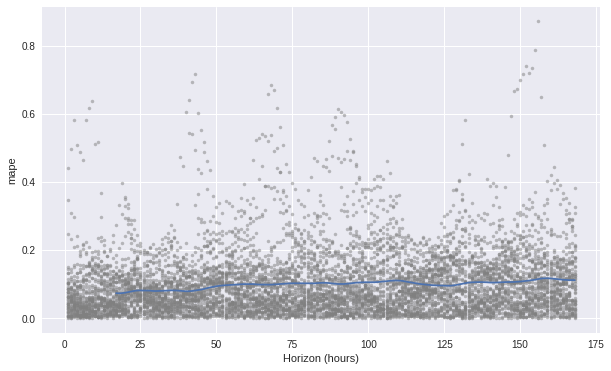

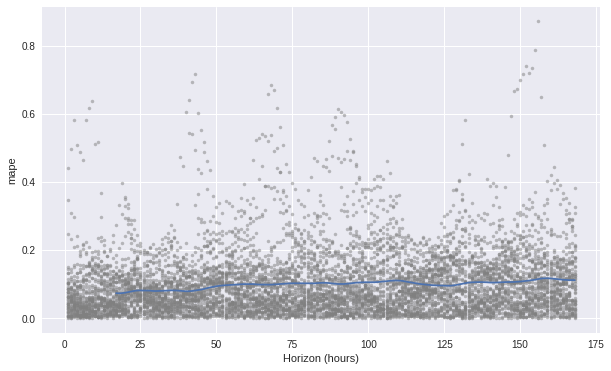

In [33]:
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv_nonzero, 'mape')

# Plotando as previsões (os pntos ciznas) e a media do erro (linha azul)
# NO caso est´a bem estável em todo o tempo
## INfelismente está duplicado

## Testando se esse modelo é melhor que a baseline

In [34]:
baseline_yhat = []
for date in (df_cv_nonzero['ds'] - pd.Timedelta(7,'D')):
    baseline_yhat.append(train[train['ds'] == date]['y'].values[0])
df_cv_nonzero['baseline'] = baseline_yhat

In [35]:
# e usarmos somente a baseline
mape(df_cv_nonzero['y'], df_cv_nonzero['baseline'])

0.1113291344840162

In [36]:
# Com nosso modelo
mape(df_cv_nonzero['y'], df_cv_nonzero['yhat'])

0.09756947380099279

In [37]:
# Juntando baseline + modelo
mape(df_cv_nonzero['y'], 0.1*df_cv_nonzero['baseline']+0.9*df_cv_nonzero['yhat'])

0.0966641013363866